In [1]:
import numpy as np
import freud
import math
import gsd.hoomd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
#VERIFY is the file suffix
VERIFY='ideal' 

In [3]:
#Trim and/or rotate initial file
if VERIFY=='ideal':
    scale=0.917
    snap = gsd.hoomd.open('ideal_tiling.gsd', 'rb')[0]
    box, positions  = [1000, 1000, 0, 0, 0, 0], snap.particles.position

    aq = freud.locality.AABBQuery(box, positions)
    nlist = aq.query(positions, {'r_max': 0.97, 'exclude_ii':True}).toNeighborList()
    trimmed_positions = positions[nlist.neighbor_counts>0]
    
    s = gsd.hoomd.Snapshot()
    s.particles.N = len(trimmed_positions)
    s.particles.types = ['A']
    s.particles.typeid = ['0']*s.particles.N
    s.particles.position = trimmed_positions

    with gsd.hoomd.open(name=VERIFY + '_trimmed.gsd', mode='wb') as f:
        f.append(s)   
else:
    scale=0.964
    snap = gsd.hoomd.open('flattened_simulation.gsd', 'rb')[0]
    box, positions  = [1000, 1000, 0, 0, 0, 0], snap.particles.position

    aq = freud.locality.AABBQuery(box, positions)
    nlist = aq.query(positions, {'r_max': 1.0, 'exclude_ii':True}).toNeighborList()
    trimmed_positions = positions[nlist.neighbor_counts>0]
    dec_order = freud.order.Hexatic(k=10)
    dec_order.compute(system=(box, trimmed_positions))
    rotation = np.mean(np.angle(dec_order.particle_order))/2

    r = R.from_quat([math.cos(rotation), math.sin(rotation), 0, 0])
    rotated_positions = trimmed_positions @ r.as_matrix()

    s = gsd.hoomd.Snapshot()
    s.particles.N = len(rotated_positions)
    s.particles.types = ['A']
    s.particles.typeid = ['0']*s.particles.N
    s.particles.position = rotated_positions

    with gsd.hoomd.open(name=VERIFY + '_trimmed.gsd', mode='wb') as f:
        f.append(s)   


In [4]:
#Write the neighbour and position lists
def write_txt(thresh):
    snap = gsd.hoomd.open(VERIFY + '_trimmed.gsd', 'rb')[0]
    aq2 = freud.locality.AABBQuery(box, positions)
    nlist2 = aq2.query(positions, {'r_max': thresh, 'exclude_ii':True}).toNeighborList()

    np.set_printoptions(suppress=True)
    np.savetxt("P_" + VERIFY + ".txt", positions.flatten(), fmt='%4f')
    np.savetxt("NL_" + VERIFY + ".txt", nlist2[:].flatten(), fmt='%4d')  

if VERIFY=='ideal': write_txt(0.97)
else: write_txt(1.1)

If necessary, now run the lifting code. Arguments following the executable's name are
-  The name of the gsd file to analyze
-  The number of queue threads
-  The number of neighbor list searching threads per queue thread
-  The number of visited list searching threads per neighbour list searching thread
-  The index of the origin point

In [5]:
!./lift ideal 1 2 2 0 0.917

Time taken was 2.086785


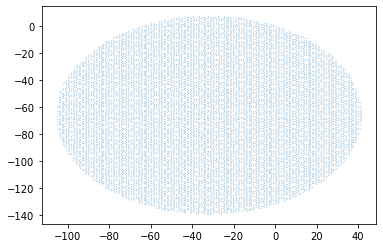

In [6]:
#Test the projection
PI=np.pi
Q = np.array([[0, 1*scale, 0],                                             
              [np.sin(2*PI/5)*scale, np.cos(2*PI/5)*scale, 0],                        
              [np.sin(4*PI/5)*scale, np.cos(4*PI/5)*scale, 0],                        
              [np.sin(6*PI/5)*scale, np.cos(6*PI/5)*scale, 0],                        
              [np.sin(8*PI/5)*scale, np.cos(8*PI/5)*scale, 0]])

H = np.loadtxt('H_' + VERIFY + '.txt')
H = H.reshape((int(len(H)/5),5))

proj = Q.T @ H.T

plt.scatter(proj[0], proj[1], s=0.01)
plt.show()

s = gsd.hoomd.Snapshot()
s.particles.N = len(proj.T)
s.particles.types = ['A']
s.particles.typeid = ['0']*s.particles.N
s.particles.position = proj.T

with gsd.hoomd.open(name=VERIFY + '_recon.gsd', mode='wb') as f:
    f.append(s)
